# HCI Week 4 - Coronagraphs Part II
*Matthew Kenworthy // Leiden Observatory*

Today we cover encircled energy plots and diffrent telescope PSFs.

**IMPORTANT** it is okay to cut and paste and reuse code from your previous Practicums! I am not expecting you to type everything out again. You now have developed your own codes and plotting routines, please reuse them if you can. This is what most researchers do from day to day.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def displC(c,trim=0):
    # displC - display a Complex number c as four plots
    #          as a (Real, Imaginary) pair and as
    #          an Amplitude, Phase plot
    #          optionally cut out the central square with size trim by trim pixels   
    c2 = np.copy(c)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = c.shape
        dx = int((nx-trim) / 2)
        dy = int((nx-trim) / 2)
        c2 = c[dx:dx+trim,dy:dy+trim]
        
    # set up the plot panels
    fig=plt.figure(figsize=(10,8))
    axre = fig.add_subplot(221)
    axim = fig.add_subplot(222)
    axamp = fig.add_subplot(223)
    axpha = fig.add_subplot(224)
    # plot out the panels
    im = axre.imshow(c2.real)
    im = axim.imshow(c2.imag)
    im = axamp.imshow(np.abs(c2))
    im = axpha.imshow(np.angle(c2))
    
    axre.set_title('Real')
    axim.set_title('Imag')
    axamp.set_title('Amplitude')
    axpha.set_title('Phase')
    plt.show()
    
def plotCAmpl(Iorig, GAMMA=4, RANGE=None, plotnow=True, trim=0):
    '''display a complex valued image

    takes complex 2D array as input, returns an
    [N,3] RGB image for display

    if RANGE=(min,max) is given, it will set image intensity
    to 0 and 1 for these values and BLACK and WHITE
    colours for out of range amplitude values respectively

    the returned image has AMPLITUDE as brightness and
    PHASE as colour:

    RED    YELLOW   BLUE   GREEN
    0        90     180     270  degrees phase

    The image is scaled by a GAMMA factor (defaults to 4)
    to emphasize smaller amplitudes

    Set plotnow=False to stop display

    Returns a MxNx3 image suitable for display

    '''
    import numpy as np
    PI = 4 * np.arctan(1)
    I = np.copy(Iorig)
    if (trim>0): # if the user specifies a trim value, cut out the centre of the image
        (nx,ny) = I.shape
        dx = int((nx-trim) / 2)
        dy = int((nx-trim) / 2)
        I = I[dx:dx+trim,dy:dy+trim]
        
    # calculate amplitude
    ampl = (abs(I)).real

    if RANGE is None:
        ampl = ampl / np.amax(ampl)
    else:
        ampl = (ampl - RANGE[0]) / abs(RANGE[1] - RANGE[0])
        ampOVER  = (ampl > 1)
        ampUNDER = (ampl < 0)
        ampl[ampOVER]  = 1
        ampl[ampUNDER] = 0

    # apply gamma to amplitude
    ampl = np.power(ampl, 1./GAMMA)

    # normalise phase from 0 to 1
    phse = (np.angle(I) / (2*PI)) + 0.5

    # make an RGB array
    img = np.zeros((I.shape[0], I.shape[1], 3), dtype=float)

    # red
    red = abs(phse - 0.625) * 4 - 0.5
    red = np.maximum(red, 0)
    red = np.minimum(red, 1)

    # green
    grn = 2 - abs(phse - 0.5) * 4
    tmp = np.where(grn > 1)
    grn[tmp] = 2. - grn[tmp]

    # blue
    blu = 1 - abs(phse - 0.5) * 4
    blu = np.maximum(blu, 0)

    img[:,:,0] = ampl * red
    img[:,:,1] = ampl * grn
    img[:,:,2] = ampl * blu

    # mark out of range points with RGB color
    if RANGE:
        img[ampOVER,:]  = (1,1,1)
        img[ampUNDER,:] = (0,0,0)

    if plotnow:
        # modified for ipython notebooks
        plt.imshow(img, aspect='equal',vmin = 0., vmax = 1., interpolation='nearest')

    return(img)



def padcplx(c,pad=5):
    # padcplx - puts a Complex array in the centre of a zero-filled Complex array
    #           pad defines the padding multiplier for the output array
    (nx, ny) = c.shape
    bignx = nx*pad
    bigny = ny*pad
    big_c = np.zeros((bignx,bigny),dtype=complex)

    dx = int((nx * (pad-1)) / 2)
    dy = int((ny * (pad-1)) / 2)

    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

def FFT(c,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfA = fftshift(fft2(ifftshift(padcplx(c,pad))))
    return psfA

def IFFT(cb,pad=5):
    """FFT - carry out the complex Fourier transform (with optional padding)
    and return the FFT padded array"""
    from numpy.fft import fft2,fftshift,ifft2,ifftshift
    psfB = fftshift(ifft2(ifftshift(padcplx(cb,pad))))
    return psfB

def circle_mask(im, xc, yc, rcirc):
        ny, nx = im.shape
        y,x = np.mgrid[0:nx,0:ny]
        r = np.sqrt((x-xc)*(x-xc) + (y-yc)*(y-yc))
        return ( (r < rcirc))

def r_theta(im, xc, yc):
    # returns the radius rr and the angle phi for point (xc,yc)
    ny, nx = im.shape
    yp, xp = np.mgrid[0:ny,0:nx]
    yp = yp - yc
    xp = xp - xc
    rr = np.sqrt(np.power(yp,2.) + np.power(xp,2.))
    phi = np.arctan2(yp, xp)
    return(rr, phi)

def phi_ramp(im, npx, npy):
    ny, nx = im.shape
    ly = np.linspace(-0.5, 0.5, ny) * np.pi * npy * 2
    lx = np.linspace(-0.5, 0.5, nx) * np.pi * npx * 2
    
    x, y = np.meshgrid(lx, ly) 
    return(x+y)

def coro(A, m, N, nsamp):
    B = FFT(A,nsamp)
    C = m * B
    D = IFFT(C,1)
    E = N * D
    F = FFT(E,1)

    return(B,C,D,E,F)

def logit(im, minlog=-8):
    # logit - takes the log10 of an image and rounds up tiny logs to minlog so that displC()
    #         works better
    imout = np.copy(im)
    logimout = np.log10(imout)
    logimout[(logimout<minlog)] = minlog
    return(logimout)

In [2]:
# you can use your own routines if you prefer

def Isum(c):
    return (np.sum(c * c.conjugate()).real)

def xaxis_energy(im, xr):
    ny, nx = im.shape
    xc = int((nx-1) / 2.)
    yc = int((ny-1) / 2.)
    sli = im[yc,xc-xr:xc+xr+1]
    return((sli*np.conjugate(sli)).real)
'''
def ee(im, xc, yc, r_ap):
    r, t = r_theta(im, xc, yc)
    
    eout = np.zeros_like(r_ap)
    
    for i, rnow in enumerate(r_ap):
        eout[i] = Isum(im * (r < rnow))
    
    return(eout)
'''
    
def ee(im, xc, yc, r_ap):
    (rr, phi) = r_theta(im, xc, yc) #Returns the radius rr and angle phi for point (xc, yc)
    Intensity = Isum(im)            #This corresponds to the total energy of the image
    
    Encircled_Energy = []
    for i,b in enumerate(r_ap):
        Circle = (rr < b)
        Energy = Isum(Circle*im) / Intensity #Energy inside the circle defined above
        Encircled_Energy.append(Energy)  
    return Encircled_Energy


## Encircled Energy Part 2
You've calculated the PSF profile and encircled energy for filled circular telescope pupils.

Many telescopes have a large primary mirror that reflects the light onto a secondary mirror, which then forms the focus of the telescope at either a Cassegrain, Gregorian, or Naysmith focus. The secondary mirror blocks light from the centre of the primary telescope, along with the shadows of the secondary support struts that hold the secondary mirror above the primary mirror. This is referred to as the *secondary obscuration*.

Assume the same telescope pupil geometry as in Week 3 - 101 by 101 pixels on a square array with the pupil touching all four edges of the square, and label it `A`, with a total intensity of `100.0` energy units.

** Q1 (6 points):** Calculate encircled energy plots for 0, 15, and 30 percent secondary obscuration in the center of the telescope pupil. Assume the secondary obscuration is circular and concentric with the telescope pupil and is completely opaque (amplitude is zero). Normalise the peak of each of the PSFs to unity before plotting them. Overplot all three curves on the same plot. 0 to 10 $\lambda/D$. Start from a radius of 1 pixel to avoid a divide by zero error.

What is the encircled energy at 1.22 $\lambda/D$ for all three secondary obscuration sizes?

** Q2 (2 points):** What happens to the relative intensities of the first and second Airy rings as the secondary obscuration size increases?

** Q3 (2 points):** Why do the diffraction minima not move significantly as the secondary obscuration increases?


The fraction at r = 1.22L/D for 0.000000 is: 0.800180
The fraction at r = 1.22L/D for 0.150000 is: 0.770056
The fraction at r = 1.22L/D for 0.300000 is: 0.694226


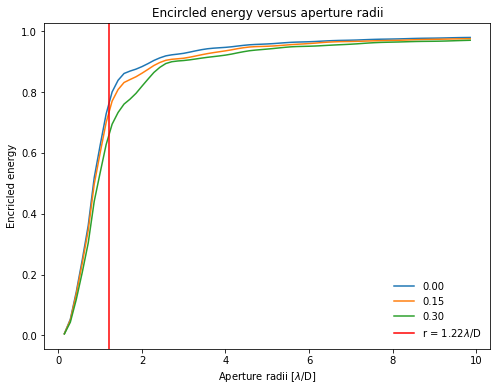

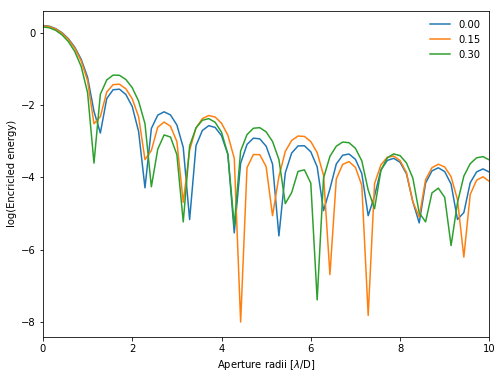

In [3]:
### write answers below here

# Q1 answer

dtel = 101 # diameter of telescope pupil in pixels
nsamp = 7
Itotal = 100.0

im = np.zeros((dtel,dtel))
xc    = (dtel-1.) / 2.
yc    = (dtel-1.) / 2.
rcirc = (dtel-1.) / 2.

Values = [0.0, 0.15, 0.3] #Secondary obscuration size

plt.figure(figsize=(8, 6))
for k in range(len(Values)):

    if Values[k] == 0.0:
        Pupil = circle_mask(im, xc, yc, rcirc) #No secondary
        
    else:
        Pupil2 = (circle_mask(im, xc, yc, rcirc*Values[k]) == 0) #Secondary with a given size
        Pupil  = Pupil2*circle_mask(im, xc, yc, rcirc)

    Pupil_1 = padcplx(Pupil, nsamp)

    A = (Pupil_1 / np.sqrt(Isum(Pupil_1)))*np.sqrt(Itotal)
    B = FFT(A, pad = 1)
    
    NORM = (dtel*nsamp)
    Bn = B / NORM

    Radii = np.arange(1, 10 * nsamp)
    Center = (dtel - 1.)*nsamp / 2.
    Encircled_energy = ee(Bn, Center, Center, Radii)
    
    Fraction = Encircled_energy[int(1.22 * nsamp)] #Encircled energy
    print('The fraction at r = 1.22L/D for %f is: %f'%(Values[k],Fraction))
    
    plt.plot(Radii/nsamp , Encircled_energy, label = '%1.2f'%Values[k])       #Radii in units of Lambda/D

plt.title('Encircled energy versus aperture radii')
plt.xlabel(r'Aperture radii [$\lambda$/D]')
plt.ylabel('Encricled energy')
plt.axvline(1.22, color = 'red', label = r'r = 1.22$\lambda$/D')
plt.legend(frameon = False, loc = 'best')

# Q2 answer
plt.figure()
plt.figure(figsize=(8, 6))
for k in range(len(Values)):
    #Pupil = (circle_mask(im, xc, yc, rcirc*Values[k]) == 0)
    if Values[k] == 0.0:
        Pupil = circle_mask(im, xc, yc, rcirc)
        
    else:
        Pupil2 = (circle_mask(im, xc, yc, rcirc*Values[k]) == 0)
        Pupil  = Pupil2*circle_mask(im, xc, yc, rcirc)

    Pupil_1 = padcplx(Pupil, nsamp)

    A = (Pupil_1 / np.sqrt(Isum(Pupil_1)))*np.sqrt(Itotal)
    #print('Normalised intensity: %3.1f'%Isum(A))
    B = FFT(A, pad = 1)
    
    NORM = (dtel*nsamp)
    Bn = B / NORM
    Center = (np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp #New axis center
    Cut = xaxis_energy(Bn, 10*nsamp)
    plt.plot(Center, logit(xaxis_energy(Bn, 10 * nsamp)), label = '%1.2f'%Values[k])
plt.xlim(0,10)    
plt.xlabel(r'Aperture radii [$\lambda$/D]')
plt.ylabel('log(Encricled energy)')
plt.legend(frameon = False, loc = 'best')

#As can be seen from this plot, the relative intensitie of the first and second Airy rings are strongly affected
#by the size of the second obscuration. When there's no second obscuration the first ring is slightly brighter than
#the second ring. However, as the second obscuration size increases, the difference is stronger. The first ring
#has become brighter while the second ring has dimmed by almost two orders of magnitude. 

# Q3 answer

#The minima do not move significantly as the secondary obscuration increases because we are using far-field 
#approximation so the diffraction pattern is observed at a distance D large enough to avoid problems that would
#pop-up when using near-field where the light rays are not parallel. 

Add secondary supports to the telescope pupil. There should be four of them, equally spaced around the circumference of the telescope pupil, connecting the edges of the primary mirror to the secondary mirror. All four secondary mirror supports should have a width of 5% of the telescope pupil's diameter.

**Q4 (5 points):** Make three PSF images, and display them using `plotCAmpl(xxx,trim=71)`:

  * The unobstructed pupil
  * the pupil with 15% secondary obscuration,
  * The pupil with 15% obscuration and the seconday supports described above.

 What is the effect of the secondary support structures in the PSF?

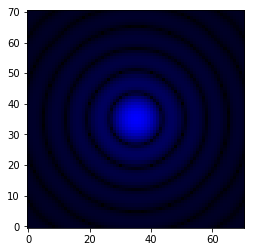

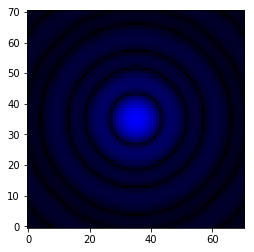

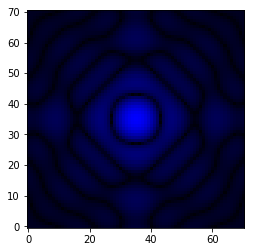

In [4]:
# Q4 answer here
im = np.zeros((dtel,dtel))
xc    = (dtel-1.) / 2.
yc    = (dtel-1.) / 2.
rcirc = (dtel-1.) / 2.

Values = [0.0, 0.15]
SpiderWidth = 0.05

plt.figure(figsize=(8, 6))

def Plot(A, B):
    
    if A == 0.0:
        
        Pupil = circle_mask(im, xc, yc, rcirc)
    else:
        Pupil2 = (circle_mask(im, xc, yc, rcirc*A) == 0)

        if B == 0.05:
            
            Pupil2[int(xc - np.floor(SpiderWidth * dtel / 2.0)) : int(xc + np.floor(SpiderWidth * dtel / 2) + 1.0), 0 : dtel] = 0
            Pupil2[0 : dtel, int(yc - np.floor(SpiderWidth * dtel / 2)) : int(yc + np.floor(SpiderWidth * dtel / 2) + 1)] = 0
        
        Pupil  = Pupil2*circle_mask(im, xc, yc, rcirc)

    
        
    Pupil_1 = padcplx(Pupil, nsamp)

    A = (Pupil_1 / np.sqrt(Isum(Pupil_1)))*np.sqrt(Itotal)
    #print('Normalised intensity: %3.1f'%Isum(A))
    B = FFT(A, pad = 1)
    
    NORM = (dtel*nsamp)
    Bn = B / NORM
    
    plt.figure()
    Image = plotCAmpl(abs(Bn)**2, trim = 71)
    
Plot(0.0, False)  #No obscuration 
Plot(0.15, False) #0.15 Obscuration
Plot(0.15, 0.05)  #0.15 obscuration + Spider

#In the first case when we have no secondary obscuration the PSF is spherically symmetric. However, once the spider 
#support is placed, the symmetry is broken, creating multiple 'local maxima' in a same ring. This is caused because
#the diffraction patter is now a convolution between the spider and the secondary mirror. 

## More Coronagraphs and the effect of Secondary Obscurations

Last time, you saw that the Lyot coronagraph can suppress on-axis sources. This week, we will look at two other coronagraphs that are used in modern telescopes both on the ground and proposed for space missions. These are some of the *small angle coronagraphs* which can image planets and disks around stars at small angular separations.

### Vortex (focal plane) coronagraph

In the focal plane mask `m`, a phase ramp is added going from 0 to $n\pi$ radians around a central point, where $n$ denotes the *order* of the vortex. The star is put on the central point of the vortex mask, with the planet off to one side. 

A pupil mask `N` then masks out as much of the starlight as possible, while maximising the amount of planet light passing through to the final focal plane `F`.

Calculate the on-axis transmission for the $n=4$ vortex coronagraph and off-axis transmission for a planet at $3 \lambda/D$ which is 10000 times fainter in intensity than the central star.

Display the pupil at position `D` in the vortex coronagraph for the star and the planet with `displC(xxx,151)`.

**Q5 (2 points):** What has happened to the flux of the star and the planet in coronagraph plane `D`?

Pick a mask for `N` that rejects the star flux but passes the planet flux.

Show that the star light is rejected by your Lyot pupil plane mask by plotting the cut across the PSF of both star and planet using the `xaxis_energy` from last Practicum, and also plot the star before the coronagraph in plane `B` to show how much starlight has been suppressed. Label the y-axis in log10 units of normalised intensity, using the telescope PSF with no coronagraph from plane `B` as your reference PSF where the peak intensity is 1.

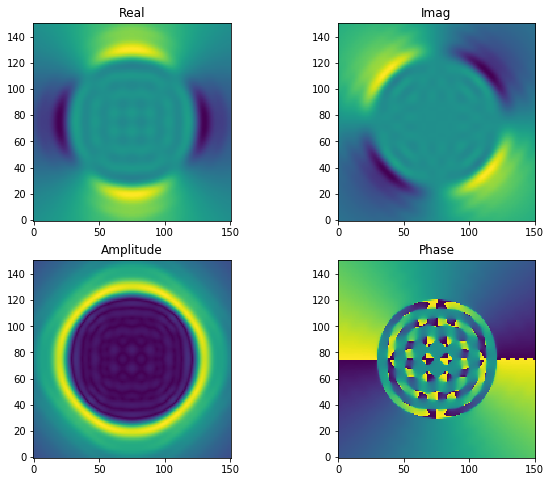

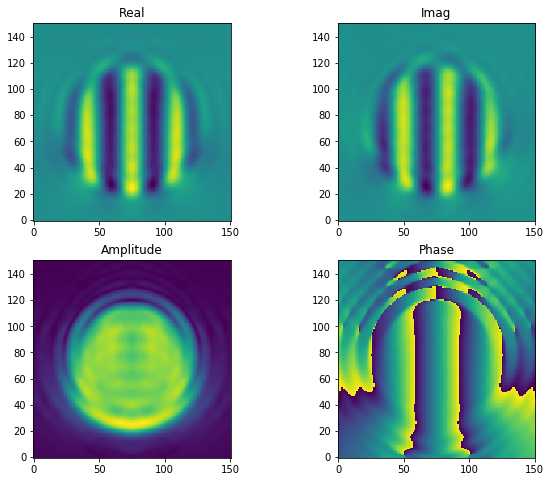

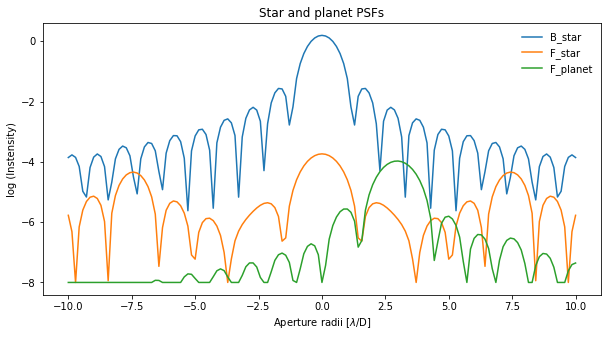

In [5]:
# code here

Pupil_1 = circle_mask(im, xc, yc, rcirc)
A       = padcplx(Pupil_1, nsamp)                 #Pupil Normalised
A       = (A / np.sqrt(Isum(A)))*np.sqrt(Itotal)

n = 4 # Vortex order.
radius, angle  = r_theta(im, xc, yc)
angle         *= n / 2.
Vortex         = padcplx(np.exp(1j * angle), nsamp)

N      = padcplx(im, nsamp) 
A_star = padcplx(A, 1) #Creating the star
#Ramp           = phi_ramp(A, 0.2*nsamp, 0) #To test question 8
#A_star = padcplx(A * np.exp(1j * Ramp), 1)

Planet_norm    = Itotal / 10000 # Planet 10000 times fainter than the star.
Ramp           = phi_ramp(A, 3*nsamp, 0)
A_planet       = padcplx(A * np.exp(1j * Ramp), 1)
A_planet       = A_planet / np.sqrt(Isum(A_planet)) * np.sqrt(Planet_norm)
#print (Isum(A_planet))

B_star, C_star, D_star, E_star, F_star = coro(A_star, Vortex, N, 1)               #Using coro
B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, Vortex, N, 1)

displC(D_star, 151)
displC(D_planet, 151)

#Now the same as above but using N with size 0.83 because it was the number found in Week_3 to maximize the
#planet's flux in comparison to the star's flux. 

N = padcplx(circle_mask(im, xc, yc, 0.83 * xc), pad = nsamp)
B_star, C_star, D_star, E_star, F_star = coro(A_star, Vortex, N, 1)
B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, Vortex, N, 1)

B_star   = B_star / (dtel * nsamp)
F_star   = F_star / (dtel * nsamp)
F_planet = F_planet / np.sqrt(Isum(F_planet)) * np.sqrt(Planet_norm)

plt.figure(figsize=(10,5))
plt.plot((np.arange(10 * nsamp* 2 + 1)  - 10 * nsamp) / nsamp, logit(xaxis_energy(B_star, 10 * nsamp)),label = "B_star")
plt.plot((np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp, logit(xaxis_energy(F_star, 10 * nsamp)), label = "F_star")
plt.plot((np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp, logit(xaxis_energy(F_planet, 10 * nsamp)), label = "F_planet")
plt.xlabel("Aperture radii [$\lambda$/D]")
plt.ylabel("log (Instensity)")
plt.title("Star and planet PSFs")
plt.legend(frameon = False, loc = 'best')
plt.show()

# Q5 answer here

#As can be seen from the display plots the flux of the star in coronagraph plane D has a minimum along the 
#optical axis because it is the place where we have located our vortex mask. This creates a maximum ring around
#it containing the information of the star which eventually will be suppresed at plane N. 
#In addition, the planet in plane D it is not strongly affected by the vortex because its light comes from a 
#different angle, not alligned with the optical axis. Thus, the ligh passes though and it's not strongly decreased
#as the star's. 

#In plane F, we see that the star's brightness has decreased dramatically creating high contrast, causing the planet
#to pop-up. The star is 10000 brighter than the planet, however after the coronograph the star is less than ~1 
#order of magnitude stronger than the planet. 


### The Vortex coronagraph with a secondary obscuration

Repeat the PSF plots from the previous question for the vortex coronagraph but with a 30% secondary obscuration in the telescope.

** Q6 (1 point):** Has the on-axi vortex coronagraph suppression increased or decreased? 

** Q7 (2 points):** What is the effect of the secondary obscuration in the Lyot stop plane?


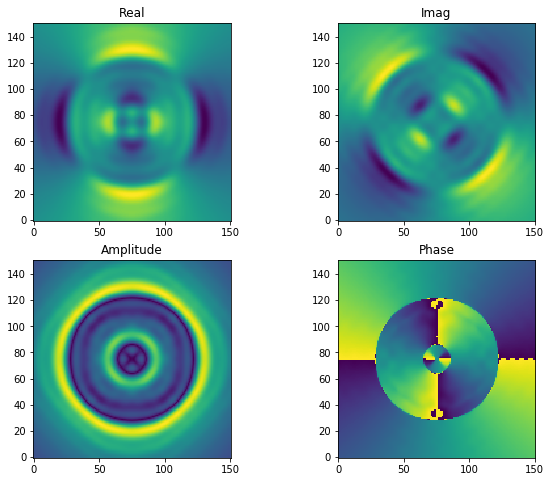

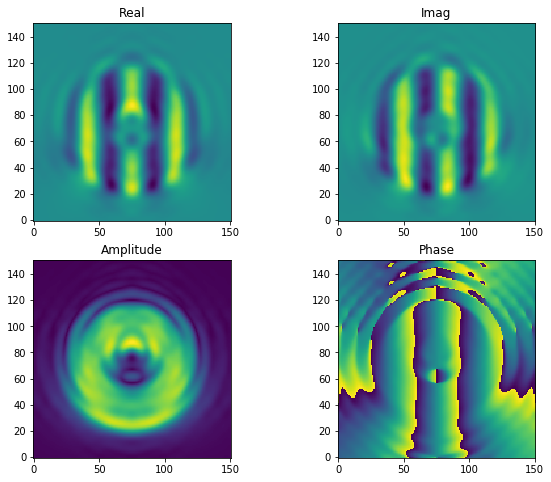

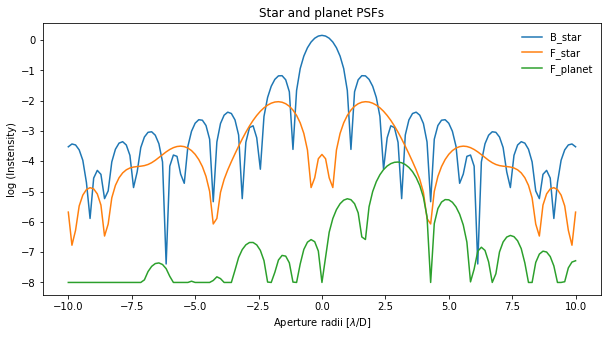

In [ ]:
# code here

Pupil_1 = (circle_mask(im, xc, yc, 0.3*rcirc) == 0) #30% secondary obscuration
Pupil_2 = Pupil_1*circle_mask(im, xc, yc, rcirc)
A       = padcplx(Pupil_2, nsamp)                 #Pupil Normalised
A       = (A / np.sqrt(Isum(A)))*np.sqrt(Itotal)

n = 4 # Vortex order.
radius, angle  = r_theta(im, xc, yc)
angle         *= n / 2.
Vortex         = padcplx(np.exp(1j * angle), nsamp)

N      = padcplx(im, nsamp) 
A_star = padcplx(A, 1) #Creating the star


Planet_norm    = Itotal / 10000 # Planet 10000 times fainter than the star.
Ramp           = phi_ramp(A, 3*nsamp, 0)
A_planet       = padcplx(A * np.exp(1j * Ramp), 1)
A_planet       = A_planet / np.sqrt(Isum(A_planet)) * np.sqrt(Planet_norm)
#print (Isum(A_planet))

B_star, C_star, D_star, E_star, F_star = coro(A_star, Vortex, N, 1)               #Using coro
B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, Vortex, N, 1)

displC(D_star, 151)
displC(D_planet, 151)

#Now the same as above but using N with size 0.83 because it was the number found in Week_3 to maximize the
#planet's flux in comparison to the star's flux. 

N = padcplx(circle_mask(im, xc, yc, 0.83 * xc), pad = nsamp)
B_star, C_star, D_star, E_star, F_star = coro(A_star, Vortex, N, 1)
B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, Vortex, N, 1)

B_star   = B_star / (dtel * nsamp)
F_star   = F_star / (dtel * nsamp)
F_planet = F_planet / np.sqrt(Isum(F_planet)) * np.sqrt(Planet_norm)

plt.figure(figsize=(10,5))
plt.plot((np.arange(10 * nsamp* 2 + 1)  - 10 * nsamp) / nsamp, logit(xaxis_energy(B_star, 10 * nsamp)),label = "B_star")
plt.plot((np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp, logit(xaxis_energy(F_star, 10 * nsamp)), label = "F_star")
plt.plot((np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp, logit(xaxis_energy(F_planet, 10 * nsamp)), label = "F_planet")
plt.xlabel("Aperture radii [$\lambda$/D]")
plt.ylabel("log (Instensity)")
plt.title("Star and planet PSFs")
plt.legend(frameon = False, loc = 'best')
plt.show()

# Q6 answer here

#The on-axis vortex coronagraph suppression in this case decreased in comparison to the last question. The main
#feature one can see is that the star keeps on being brighter than the planet at least by two orders of magnitude. 

# Q7 answer here

#The effect of the secondary obscuration in the Lyot stop plane is to diminish the merits of the vortex coronagraph.
#The starlight is not longer located at the enter but in a ring around it. The vortex cannot longer cancel out as 
#much light as possible which is the main goal, making the star to still look brighter than the planet because
#more starlight can pass through without being rejected. 


### The APP Coronagraph

The Apodizing Phase Plate (APP) is not a coronagraph in the classical Lyot sense, but it is an apodizer implemented in phase. There is no focal plane mask `m`.
The phase in the pupil plane `N` is modified by having the APP pattern added to it.

Calculate the same plots for star and planet for the APP coronagraph. The APP phase pattern is stored in `app_phse.fits` and the amplitude mask (a 33% secondary obscuration telescope pupil) is in `app_ampl.fits`.


In [ ]:
from astropy.io import fits

app_ampl, h1 = fits.getdata('app_ampl.fits',header=True)
app_phse, h2 = fits.getdata('app_phse.fits',header=True)

# code for the PSF plots below here

Pupil_3 = app_ampl * circle_mask(im, xc, yc, rcirc)

A_star = padcplx(Pupil_3, nsamp)
#Ramp           = phi_ramp(Pupil_3, 0.2*nsamp, 0)   #To test question 8
#A_star = padcplx(Pupil_3 * np.exp(1j * Ramp), nsamp)

Ramp           = phi_ramp(Pupil_3, 3, 0)
A_planet       = padcplx(Pupil_3 * np.exp(1j * Ramp), nsamp)
A_planet       = A_planet / np.sqrt(Isum(A_planet)) * np.sqrt(Planet_norm)

No_mask_m = padcplx(np.ones((dtel, dtel)), nsamp)
N_APP = padcplx(np.exp(1j * app_phse), nsamp)

B_star, C_star, D_star, E_star, F_star = coro(A_star, No_mask_m, N_APP, 1)
B_planet, C_planet, D_planet, E_planet, F_planet = coro(A_planet, No_mask_m, N_APP, 1)

displC(F_star, 151)
displC(F_planet, 151)

B_star = B_star / np.sqrt(Isum(B_star)) * np.sqrt(Itotal)
F_star = F_star / np.sqrt(Isum(F_star)) * np.sqrt(Itotal)
F_planet = F_planet / np.sqrt(Isum(F_planet)) * np.sqrt(Planet_norm)

plt.figure(figsize=(10,5))
plt.plot((np.arange(10 * nsamp* 2 + 1)  - 10 * nsamp) / nsamp, logit(xaxis_energy(B_star, 10 * nsamp)),label = "B_star")
plt.plot((np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp, logit(xaxis_energy(F_star, 10 * nsamp)), label = "F_star")
plt.plot((np.arange(10 * nsamp * 2 + 1) - 10 * nsamp) / nsamp, logit(xaxis_energy(F_planet, 10 * nsamp)), label = "F_planet")
plt.xlabel("Aperture radii [$\lambda$/D]")
plt.ylabel("log (Instensity)")
plt.title("Star and planet PSFs")
plt.legend(frameon = False, loc = 'best')
plt.show()

## Adding tip tilt error to the star

Qualitatively describe what happens to the star flux in the Vortex and APP coronagraphs if you add $0.2 \lambda/D$ tilt in the x direction to the star's wavefront. **NOTE:** You can do this by adding the tilt in the code above, then comment it out again when you want the on-axis performance back.

**Q8 (4 points):** What does this say about the tip tilt stability required for each of the coronagraphs?

In [ ]:
# Q8 answer here

#To check this, one can uncomment the given lines in the Vortex without secondary obscuration and APP coronographs.

#When we introduce a tilt of 0.2 λ/D  in the x-direction to the start's wavefront in the Vortex coronograph 
#without second obscuration, it is clear that the star is at least 1 order of magnitude brighter than the
#planet. The contrast is degraded because we have more starlight not being rejected due to the tilt creating
#positive interference which is reflected as the increase in the star intensity in comparison to the planet. 

#This is still valid for the vortex with secondary obscuration because the diffraction patter has already changed
#affecting the contrast, making the star brighter. The til will just keep on benefit the constructive interference. 

#When we introduce a tilt of 0.2 λ/D  in the x-direction to the start's wavefront in the APP coronograph
#the star's flux increases but the change is not so strong. It seems that the APP coronograph response to a tilt
#in the incoming starlight is more stable than the Vortex one. 

*REMEMBER* to make sure your code compiles cleanly before submitting it!